In [1]:
from datetime import date
today = str(date.today())
print("Today's date:", today)
import obspy as op
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
import model_V1
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import metrics #own file
import seaborn as sns
import csv
sns.set_style('darkgrid')
sns.set_palette('dark')
print (tf.config.list_physical_devices())
print (tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  #Invalid device or cannot modify virtual devices once initialized.
  pass

Today's date: 2022-08-02
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.5.0


In [2]:
#Setting Config
config = {"dirname" : "iter3e4",
          "WeightsFileName" : ['/Pretrain_encoder.h5','/Pretrain_autoencoder.h5','/Pretrain_decoder.h5'],
          "n_clusters" : 6,
            "gamma" : 0.1,
            "batch_size" : 256,
            "maxiter" : 3e4,
            "tol" : 0.001, # tolerance threshold to stop training
            "update_interval" : 150,
            "save_interval" : 5000
}

In [8]:
#Loading Data
x_train = np.load('./x.npy',mmap_mode='r')
info = np.load('./y.npy',allow_pickle=True)

y_train = info[...,3]
y_true =  np.ndarray(shape=(len(y_train)) ,dtype = 'float32')
for i,data in enumerate(y_train):
    if data == "EQ" :
        y_true[i] = np.array(1)
    elif data == "RF":
        y_true[i] = np.array(2)
    elif data == "EN":
        y_true[i] = np.array(3)
    elif data == "car":
        y_true[i] = np.array(4)
    else :
        y_true[i] = np.array(0)
        
DEC_weightsdir = config["dirname"]
n_clusters = 6
save_dir = './results/temp/weights_{0}_1_{1}/cluster{2}'.format(str(config["gamma"]).split('.')[1],config["dirname"],str(config["n_clusters"]))

if not os.path.exists(save_dir+"/image"):
    os.makedirs(save_dir+"/image")
save_imagedir = save_dir+"/image"

print (save_dir)
print (x_train.shape)

./results/temp/weights_1_1_iter3e4/cluster6
(47049, 128, 128, 3)


# Buliding the model

In [9]:
#Buliding the autoencoder
encoder,decoder,autoencoder = model_V1.CAE(input_shape=(128, 128, 3),filters=[12, 24, 36, 48, 64],summary=False)
encoder.load_weights("./results/temp" + config["WeightsFileName"][0])
autoencoder.load_weights("./results/temp" + config["WeightsFileName"][1])
decoder.load_weights("./results/temp" + config["WeightsFileName"][2])

## adding the clustering layer into the bottelneck layer

In [10]:
# Define DCEC model
clustering_layer = model_V1.ClusteringLayer(config["n_clusters"], name='clustering')(encoder.output)
DECmodel = Model(inputs=autoencoder.input, outputs=[clustering_layer, autoencoder.output], name='DEC')
DECmodel.compile(loss=['kld', 'mse'], loss_weights=[config["gamma"], 1], optimizer='adam')
DECmodel.summary()

Model: "DEC"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_img (InputLayer)       [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv_1 (Conv2D)                 (None, 64, 64, 12)   336         original_img[0][0]               
__________________________________________________________________________________________________
Conv_2 (Conv2D)                 (None, 32, 32, 24)   2616        Conv_1[0][0]                     
__________________________________________________________________________________________________
Conv_3 (Conv2D)                 (None, 16, 16, 36)   7812        Conv_2[0][0]                     
________________________________________________________________________________________________

## initializing the weights

In [11]:
### initializing the weights using Kmean and assigning them to the model
features = encoder.predict(x_train)
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(features)
y_pred_last = np.copy(y_pred)
DECmodel.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

# DEC training

In [12]:
## parameters for the finetuning
loss = [0, 0, 0]
index = 0
index_array = np.arange(x_train.shape[0])
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
###############################################################################
### simultaneous optimization and clustering
logfile = open(save_dir + '/dcec_log.csv', 'w')
logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'purity', 'nmi', 'ari', 'L', 'Lc', 'Lr'])
logwriter.writeheader()
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(config["maxiter"])):
    if ite % config["update_interval"] == 0:
        if len(x_train) > 25000:
            q1, _  = DECmodel.predict(x_train[0:25000], verbose=0)
            q2, _  = DECmodel.predict(x_train[25000:],verbose=0)
            q = np.concatenate((q1,q2),axis=0)
        else :
            q, _  = DECmodel.predict(x_train, verbose=0)
            
        # update the auxiliary target distribution p 
        p = target_distribution(q)  
        # evaluate the clustering performance
        y_pred = q.argmax(1) 
        print('Iter %d: ' % (ite), ' ; L = {0} Lc = {1} Lr = {2}'.format(loss[0],loss[1],loss[2]))  
        truelist,predlist,predlist_km = metrics.tracker(y_train,y_pred,n_clusters=n_clusters)
        purity = np.round(metrics.purity_score(truelist,predlist_km),5)
        nmi  = np.round(metrics.nmi(truelist,predlist_km),5)
        logdict = dict(iter=ite, purity=purity, nmi=nmi, L=loss[0], Lc=loss[1], Lr=loss[2])
        logwriter.writerow(logdict)
        print('Purity : {0} ,NMI : {1}'.format(purity,nmi))
        
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < config["tol"]:
            print('delta_label ', delta_label, '< tol ', config["tol"])
            break
            
    # save intermediate model
    if ite % config["save_interval"] == 0:
        # save DCEC model checkpoints
        print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
        DECmodel.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')

        #IN = encoder.predict(x)        
    idx = index_array[index * config["batch_size"]: min((index+1) * config["batch_size"], x_train.shape[0])]
    loss = DECmodel.train_on_batch(x=x_train[idx], y=[p[idx], x_train[idx]])
    index = index + 1 if (index + 1) * config["batch_size"] <= x_train.shape[0] else 0

    
# save DCEC model checkpoints
logfile.close()
print('saving model to:', save_dir + '/dcec_model_final.h5')
DECmodel.save_weights(save_dir + '/dcec_model_final.h5')
print ('finish :'+str(ite))

Iter 0:   ; L = 0 Lc = 0 Lr = 0
in cluster0 : EQnum=172,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=2,RFnum=155,ENnum=2,carnum=233
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=0
clster2->ENclass
in cluster3 : EQnum=8,RFnum=263,ENnum=0,carnum=2
clster3->RFclass
in cluster4 : EQnum=1,RFnum=85,ENnum=1,carnum=116
clster4->ENclass
in cluster5 : EQnum=355,RFnum=21,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.85802 ,NMI : 0.7005
saving model to: ./results/temp/weights_1_1_iter3e4/cluster6/dcec_model_0.h5
Iter 150:   ; L = 0.18459635972976685 Lc = 0.006472421810030937 Lr = 0.18394911289215088
in cluster0 : EQnum=183,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=2,RFnum=147,ENnum=2,carnum=227
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=0
clster2->ENclass
in cluster3 : EQnum=11,RFnum=246,ENnum=0,carnum=2
clster3->RFclass
in cluster4 : EQnum=1,RFnum=112,ENnum=1,carnum=122
clster4->ENclass
in cluster5 : EQnum=341,RFnum=18,ENn

Iter 2400:   ; L = 0.2074725478887558 Lc = 0.1590372622013092 Lr = 0.19156882166862488
in cluster0 : EQnum=155,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=127,ENnum=0,carnum=224
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=0
clster2->ENclass
in cluster3 : EQnum=1,RFnum=312,ENnum=2,carnum=2
clster3->RFclass
in cluster4 : EQnum=0,RFnum=72,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=382,RFnum=13,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.88877 ,NMI : 0.74047
Iter 2550:   ; L = 0.17303846776485443 Lc = 0.11290562152862549 Lr = 0.16174790263175964
in cluster0 : EQnum=173,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=100,ENnum=0,carnum=222
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=532,carnum=0
clster2->ENclass
in cluster3 : EQnum=3,RFnum=325,ENnum=4,carnum=4
clster3->RFclass
in cluster4 : EQnum=0,RFnum=88,ENnum=2,carnum=125
clster4->ENclass
in cluster5 : EQnum=362,RFnum=11,ENnum=0,carnum=0
clster5->

Iter 4800:   ; L = 0.1689097285270691 Lc = 0.11942356824874878 Lr = 0.1569673717021942
in cluster0 : EQnum=158,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=100,ENnum=0,carnum=224
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=348,ENnum=3,carnum=2
clster3->RFclass
in cluster4 : EQnum=0,RFnum=63,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=380,RFnum=13,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.90723 ,NMI : 0.75408
Iter 4950:   ; L = 0.20345015823841095 Lc = 0.08828345686197281 Lr = 0.19462181627750397
in cluster0 : EQnum=165,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=92,ENnum=0,carnum=221
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=532,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=349,ENnum=6,carnum=5
clster3->RFclass
in cluster4 : EQnum=0,RFnum=73,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=373,RFnum=10,ENnum=0,carnum=0
clster5->E

Iter 7200:   ; L = 0.18516699969768524 Lc = 0.11869685351848602 Lr = 0.17329731583595276
in cluster0 : EQnum=169,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=69,ENnum=0,carnum=222
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=383,ENnum=2,carnum=4
clster3->RFclass
in cluster4 : EQnum=0,RFnum=62,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=369,RFnum=9,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.92465 ,NMI : 0.7687
Iter 7350:   ; L = 0.2730299234390259 Lc = 0.13589292764663696 Lr = 0.2594406306743622
in cluster0 : EQnum=167,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=57,ENnum=0,carnum=220
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=530,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=393,ENnum=8,carnum=6
clster3->RFclass
in cluster4 : EQnum=0,RFnum=65,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=371,RFnum=8,ENnum=0,carnum=0
clster5->EQcla

Iter 9600:   ; L = 0.18250307440757751 Lc = 0.12422577291727066 Lr = 0.1700804978609085
in cluster0 : EQnum=150,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=47,ENnum=0,carnum=221
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=534,carnum=0
clster2->ENclass
in cluster3 : EQnum=1,RFnum=427,ENnum=4,carnum=5
clster3->RFclass
in cluster4 : EQnum=0,RFnum=45,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=387,RFnum=5,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.94516 ,NMI : 0.79234
Iter 9750:   ; L = 0.16656070947647095 Lc = 0.1906316578388214 Lr = 0.14749754965305328
in cluster0 : EQnum=155,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=35,ENnum=0,carnum=220
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=439,ENnum=3,carnum=6
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=383,RFnum=6,ENnum=0,carnum=0
clster5->EQcl

Iter 12000:   ; L = 0.203168123960495 Lc = 0.16566917300224304 Lr = 0.1866012066602707
in cluster0 : EQnum=164,RFnum=2,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=50,ENnum=0,carnum=226
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=408,ENnum=3,carnum=0
clster3->RFclass
in cluster4 : EQnum=0,RFnum=58,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=374,RFnum=6,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.93849 ,NMI : 0.78707
Iter 12150:   ; L = 0.18565286695957184 Lc = 0.13896766304969788 Lr = 0.1717561036348343
in cluster0 : EQnum=159,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=57,ENnum=0,carnum=226
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=407,ENnum=2,carnum=0
clster3->RFclass
in cluster4 : EQnum=0,RFnum=52,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=379,RFnum=7,ENnum=0,carnum=0
clster5->EQcl

Iter 14400:   ; L = 0.17306777834892273 Lc = 0.09405446797609329 Lr = 0.16366232931613922
in cluster0 : EQnum=156,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=16,ENnum=0,carnum=222
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=456,ENnum=3,carnum=4
clster3->RFclass
in cluster4 : EQnum=0,RFnum=46,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=382,RFnum=5,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.96105 ,NMI : 0.81639
Iter 14550:   ; L = 0.1681712418794632 Lc = 0.09731416404247284 Lr = 0.15843982994556427
in cluster0 : EQnum=158,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=13,ENnum=0,carnum=222
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=458,ENnum=2,carnum=4
clster3->RFclass
in cluster4 : EQnum=0,RFnum=45,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=380,RFnum=7,ENnum=0,carnum=0
clster5->E

Iter 16800:   ; L = 0.16687525808811188 Lc = 0.08577150106430054 Lr = 0.15829810500144958
in cluster0 : EQnum=157,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=10,ENnum=0,carnum=225
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=463,ENnum=3,carnum=1
clster3->RFclass
in cluster4 : EQnum=0,RFnum=45,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=381,RFnum=5,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.96668 ,NMI : 0.83039
Iter 16950:   ; L = 0.14752891659736633 Lc = 0.0870247632265091 Lr = 0.13882644474506378
in cluster0 : EQnum=157,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=9,ENnum=0,carnum=224
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=461,ENnum=2,carnum=2
clster3->RFclass
in cluster4 : EQnum=0,RFnum=46,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=381,RFnum=7,ENnum=0,carnum=0
clster5->EQ

Iter 19200:   ; L = 0.12751494348049164 Lc = 0.059391774237155914 Lr = 0.12157577276229858
in cluster0 : EQnum=157,RFnum=1,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=8,ENnum=0,carnum=223
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=464,ENnum=3,carnum=3
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=381,RFnum=7,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.96566 ,NMI : 0.82486
Iter 19350:   ; L = 0.18602415919303894 Lc = 0.09866270422935486 Lr = 0.1761578917503357
in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=8,ENnum=0,carnum=223
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=465,ENnum=2,carnum=3
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=382,RFnum=7,ENnum=0,carnum=0
clster5->EQ

Iter 21600:   ; L = 0.16819986701011658 Lc = 0.08321963995695114 Lr = 0.15987789630889893
in cluster0 : EQnum=155,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=8,ENnum=0,carnum=222
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=534,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=465,ENnum=4,carnum=5
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=383,RFnum=7,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.96515 ,NMI : 0.82494
Iter 21750:   ; L = 0.1945084035396576 Lc = 0.08318586647510529 Lr = 0.18618981540203094
in cluster0 : EQnum=158,RFnum=2,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=13,ENnum=0,carnum=225
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=455,ENnum=2,carnum=1
clster3->RFclass
in cluster4 : EQnum=0,RFnum=46,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=380,RFnum=8,ENnum=0,carnum=0
clster5->EQ

Iter 24000:   ; L = 0.14490610361099243 Lc = 0.06255625188350677 Lr = 0.13865047693252563
in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=9,ENnum=0,carnum=224
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=535,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=464,ENnum=3,carnum=2
clster3->RFclass
in cluster4 : EQnum=0,RFnum=42,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=382,RFnum=9,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.96617 ,NMI : 0.82614
Iter 24150:   ; L = 0.1812349557876587 Lc = 0.08190707862377167 Lr = 0.17304424941539764
in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=8,ENnum=0,carnum=222
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=465,ENnum=2,carnum=4
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=382,RFnum=7,ENnum=0,carnum=0
clster5->EQc

Iter 26400:   ; L = 0.1570407748222351 Lc = 0.055630020797252655 Lr = 0.15147776901721954
in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=9,ENnum=0,carnum=225
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=463,ENnum=2,carnum=1
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=382,RFnum=8,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.9672 ,NMI : 0.83203
Iter 26550:   ; L = 0.1582668274641037 Lc = 0.06678356230258942 Lr = 0.15158846974372864
in cluster0 : EQnum=157,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=9,ENnum=0,carnum=225
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=0
clster2->ENclass
in cluster3 : EQnum=0,RFnum=463,ENnum=2,carnum=1
clster3->RFclass
in cluster4 : EQnum=0,RFnum=44,ENnum=0,carnum=125
clster4->ENclass
in cluster5 : EQnum=381,RFnum=8,ENnum=0,carnum=0
clster5->EQcl

Iter 28800:   ; L = 0.15399973094463348 Lc = 0.05620264261960983 Lr = 0.14837945997714996
in cluster0 : EQnum=158,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=8,ENnum=0,carnum=225
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=468,ENnum=2,carnum=1
clster3->RFclass
in cluster4 : EQnum=0,RFnum=42,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=380,RFnum=6,ENnum=0,carnum=0
clster5->EQclass
Purity : 0.96925 ,NMI : 0.83475
Iter 28950:   ; L = 0.16389471292495728 Lc = 0.05441583693027496 Lr = 0.15845313668251038
in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=8,ENnum=0,carnum=224
clster1->ENclass
in cluster2 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster2->ENclass
in cluster3 : EQnum=0,RFnum=468,ENnum=2,carnum=2
clster3->RFclass
in cluster4 : EQnum=0,RFnum=42,ENnum=0,carnum=124
clster4->ENclass
in cluster5 : EQnum=382,RFnum=6,ENnum=0,carnum=0
clster5->EQ

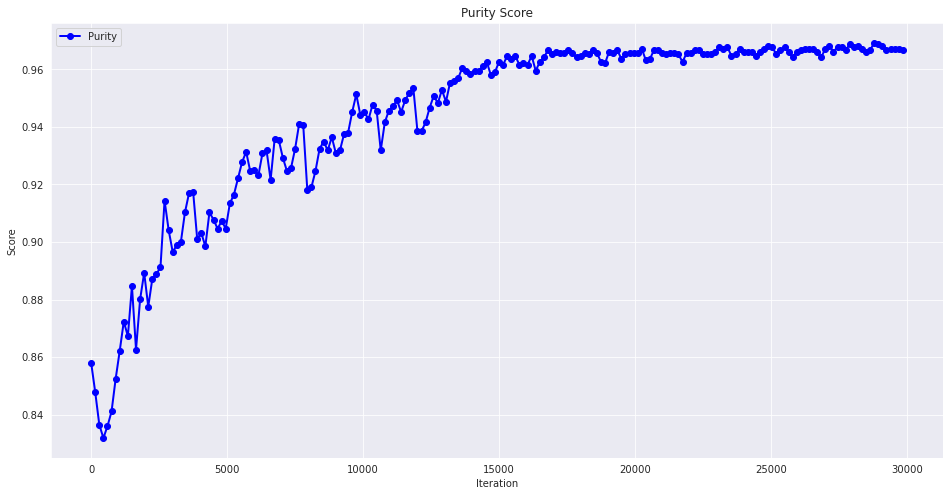

In [13]:
import csv
with open(save_dir+ '/dcec_log.csv', newline='') as csvfile:
    purity = []
    rows = csv.DictReader(csvfile)
    for row in rows:
        purity.append(float(row['purity']))
        
Iter = [i*150 for i in range(len(purity))]
values = [0,5000,10000,15000,20000,25000,30000]

plt.figure(figsize=(16,8))
plt.plot(Iter,purity,'bo-', label='Purity', linewidth=2)
plt.title('Purity Score')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Score')
plt.yticks()
plt.savefig(save_imagedir+"/Purity.jpg",dpi=1080,bbox_inches='tight', transparent=False) 
plt.show()
plt.close()

# load final model_weights

In [14]:
DECmodel.load_weights(save_dir+ '/dcec_model_final.h5')
print (save_dir+ '/dcec_model_final.h5')
enc = encoder.predict(x_train)

./results/temp/weights_1_1_iter3e4/cluster6/dcec_model_final.h5


In [16]:
kmeans = KMeans(n_clusters=n_clusters,n_init=20, random_state=87).fit(enc)
y_pred = kmeans.predict(enc)
y_pred_last = np.copy(y_pred)
centers = kmeans.cluster_centers_
enc_cen = np.append(enc,centers,axis=0)
redu = TSNE(n_components=2,perplexity=40,random_state=74).fit_transform(enc_cen)

truelist,predlist,predlist_km = metrics.tracker(y_train,y_pred_last,n_clusters=n_clusters)
print('nmi=', metrics.nmi(np.array(truelist), np.array(predlist)), 'ari=', metrics.ari(np.array(truelist), np.array(predlist)))
purity = metrics.purity_score(np.array(truelist), np.array(predlist))
print ("Purity : ", purity)

in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=43,ENnum=0,carnum=124
clster1->ENclass
in cluster2 : EQnum=0,RFnum=9,ENnum=0,carnum=225
clster2->ENclass
in cluster3 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster3->ENclass
in cluster4 : EQnum=0,RFnum=463,ENnum=2,carnum=1
clster4->RFclass
in cluster5 : EQnum=382,RFnum=9,ENnum=0,carnum=0
clster5->EQclass
nmi= 0.912649835275 ari= 0.923299324555
Purity :  0.966683751922


/home/rick/anaconda3/envs/tf-2.5/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/home/rick/anaconda3/envs/tf-2.5/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


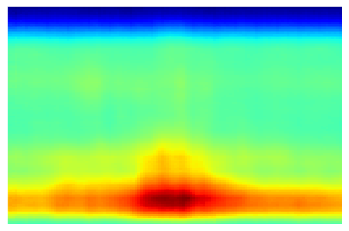

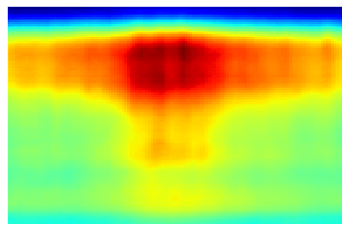

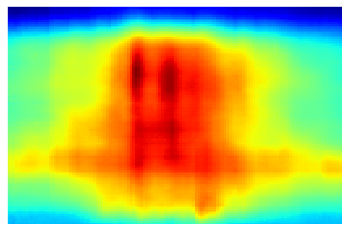

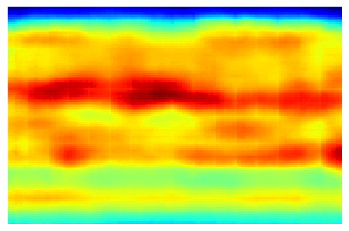

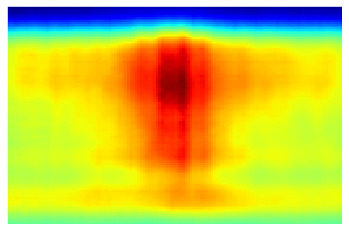

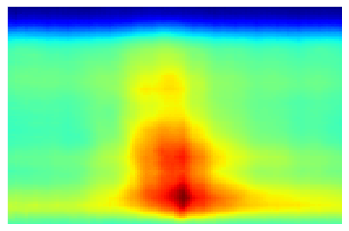

In [17]:
reconstruction_centers = decoder.predict(centers)
cen = int(len(reconstruction_centers))

for i,n in enumerate(reconstruction_centers):
    Sxx = reconstruction_centers[i][...,0]
    plt.pcolormesh(Sxx ,cmap='jet')
    plt.axes().get_xaxis().set_visible(False)
    plt.axes().get_yaxis().set_visible(False)
    num = str(i)
    #plt.savefig(save_dir+"/image/reconstruction_centers_"+num+"_.jpg",bbox_inches='tight', transparent=False) 
    plt.show()
    plt.close()

## Visualization

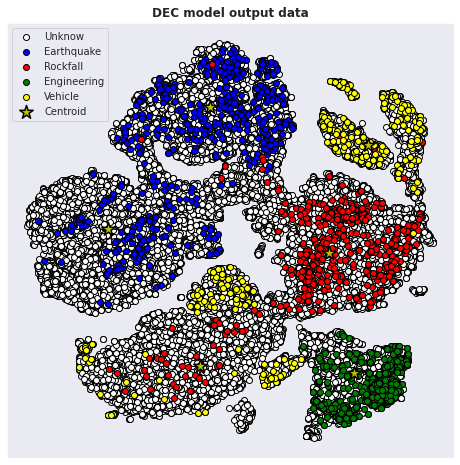

In [18]:
# 在 1x2 的網格上繪製子圖形
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# 調整圖形的外觀
#fig.subplots_adjust(top=0.85)
colors = ['white', 'blue', 'red','green','yellow']
for i in range(len(colors)):
    x = redu[:-cen , 0][y_true == i] #y_pred
    y = redu[:-cen , 1][y_true == i] #y_pred

    ax.scatter(x, y, c=colors[i] ,marker='o', edgecolors='black')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.set_title('encoded_tsne')
#centers
x0 = redu[-cen :, 0] 
y0 = redu[-cen :, 1]
ax.scatter(x0, y0,s=200, alpha=1, linewidths=1.5, c='y' ,marker='*', edgecolors='black')    

#plt.legend(range(0,10), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.legend(['Unknow','Earthquake','Rockfall','Engineering','Vehicle','Centroid'])
plt.title("DEC model output data", fontsize=12, fontweight='bold')
plt.show()
fig.savefig(save_imagedir+"/DEC_model_output_30000_x.jpg",dpi=1080,bbox_inches='tight', transparent=False) 
plt.close(fig)

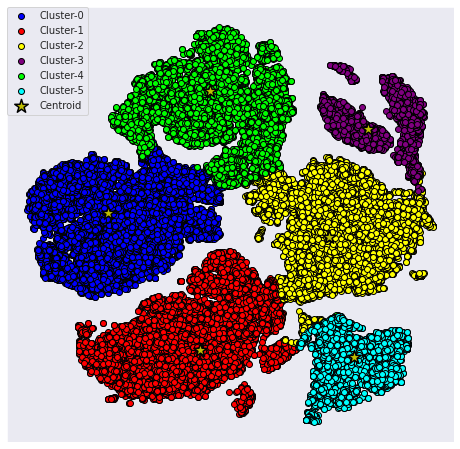

In [25]:
y_pred_trans=  np.zeros_like(y_pred_last)
for i,label in enumerate( y_pred_last) :
    if label == 0 :
        y_pred_trans[i] = np.array(0)
    elif label == 1 :
        y_pred_trans[i] = np.array(1)
    elif label == 2 :
        y_pred_trans[i] = np.array(3)
    elif label == 3 :
        y_pred_trans[i] = np.array(5)
    elif label == 4 :
        y_pred_trans[i] = np.array(2)
    elif label == 5 :
        y_pred_trans[i] = np.array(4)

# 在 1x2 的網格上繪製子圖形
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
num = ["Cluster-"+str(i) for i in range(cen)]

num.append('Centroid')

# 調整圖形的外觀
#fig.subplots_adjust(top=0.85)
#colors = ['blue', 'red', 'yellow', 'purple', 'lime', 'cyan', 'black', 'orange']
colors = ['blue', 'red', 'yellow', 'purple', 'lime', 'cyan', 'black', 'orange', 'gray', 'lightgreen', 'lightblue', 'navy', 'turquoise', 'violet', 'whitesmoke', 'rosybrown', 'darkgreen', 'crimson','tab:purple','tab:olive']

colors = [colors[i] for i in range(cen)]
#colors = ['white', 'blue', 'red', 'cyan', 'purple', 'gray', 'lime']
for i in range(len(colors)):
    x = redu[:-cen , 0][y_pred_trans == i] #y_pred
    y = redu[:-cen , 1][y_pred_trans == i] #y_pred

    ax.scatter(x, y, c=colors[i] ,marker='o', edgecolors='black')
    #ax.set_title('encoded_tsne')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
#centers
x0 = redu[-cen :, 0] 
y0 = redu[-cen :, 1]
ax.scatter(x0, y0,s=200, alpha=1, linewidths=1.5, c='y' ,marker='*', edgecolors='black')    


plt.legend(num, borderaxespad=0.)

plt.show()
fig.savefig(save_imagedir +"/DEC_model_output_30000_2.jpg",dpi=1080,bbox_inches='tight', transparent=False) 
plt.close(fig)

## Model Preformance

in cluster0 : EQnum=156,RFnum=0,ENnum=0,carnum=0
clster0->EQclass
in cluster1 : EQnum=0,RFnum=43,ENnum=0,carnum=124
clster1->ENclass
in cluster2 : EQnum=0,RFnum=463,ENnum=2,carnum=1
clster2->RFclass
in cluster3 : EQnum=0,RFnum=9,ENnum=0,carnum=225
clster3->ENclass
in cluster4 : EQnum=382,RFnum=9,ENnum=0,carnum=0
clster4->EQclass
in cluster5 : EQnum=0,RFnum=0,ENnum=536,carnum=1
clster5->ENclass


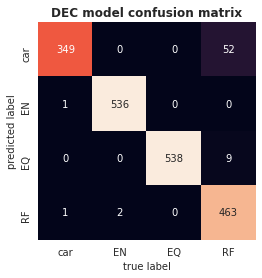

In [26]:
truelist,predlist,predlist_km = metrics.tracker(y_train,y_pred_trans,n_clusters=n_clusters)
mat = confusion_matrix(truelist,predlist)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['car','EN','EQ','RF'], yticklabels=['car','EN','EQ','RF']
            )
plt.title("DEC model confusion matrix", fontsize=12, fontweight='bold')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig(save_imagedir+"/DEC model confusion matrix.jpg",bbox_inches='tight', transparent=False) 

In [27]:
print ("Clustering Accuracy : ",metrics.accuracy_score(np.array(truelist),np.array(predlist)))
print('nmi=', metrics.nmi(np.array(truelist), np.array(predlist)), 'ari=', metrics.ari(np.array(truelist), np.array(predlist)))
Purity = []
purity = metrics.purity_score(np.array(truelist), np.array(predlist))
print ("Purity : ", purity)
Purity.append(purity)

Clustering Accuracy :  0.966683751922
nmi= 0.912649835275 ari= 0.923299324555
Purity :  0.966683751922


## Class Assignments

[10501, 10989, 9874, 3373, 8716, 3596]


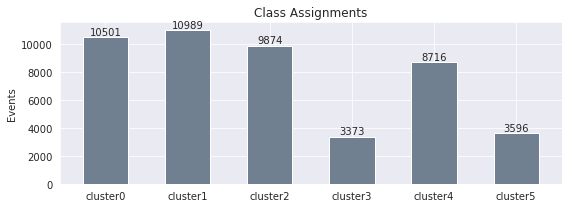

In [28]:
cen = int(len(reconstruction_centers))
classes = []
num = []
for i in range(cen):
    classnum=('cluster'+str(i))
    classx = np.sum(y_pred_trans==i)
    num.append(classx)
    classes.append(classnum)
print (num)
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(classes, num, tick_label=classes, width=0.55, color='slategray')
ax.set_title('Class Assignments')        
#ax.set_xlabel('Class')                             
ax.set_ylabel('Events')
rect = ax.patches
for rect, num  in zip(rect, num ):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, num,
            ha='center', va='bottom')
fig.tight_layout()
plt.savefig(save_imagedir+"/Class Assignments.png",bbox_inches='tight', transparent=False)
plt.show()